In [19]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import mnist
from collections import Counter

In [35]:
def load_dataset(cached_dir):
    '''
    Get MNIST data using mnist library
    :params cached_dir: folder path to cache mnist data
    :return: list of train sets and test sets
    '''
    mnist.temporary_dir = lambda: cached_dir
    train_images = mnist.train_images()
    train_labels = mnist.train_labels()
    test_images = mnist.test_images()
    test_labels = mnist.test_labels()
    
    return [train_images, train_labels, test_images, test_labels]

# load datasets
mnist_dir = '../z_datasets/MNIST/'
train_X, train_y, test_X, test_y = load_dataset(mnist_dir)

In [36]:
# shape of datasets
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [37]:
# reshape datasets
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


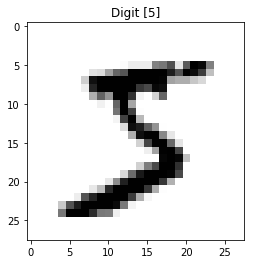

In [31]:
# view the nth image
n = 1
image = train_X[n-1].reshape(28, 28)
label = train_y[n-1]
plt.imshow(image, cmap='gray_r')
plt.title('Digit {}'.format(label))
plt.show()

In [61]:
def calculate_distance(x1, x2, r=2):
    '''
    Calculate the distance between 2 vectors.
    :params x1: vector representing data point 1
    :params x2: vector representing data point 2
    :params r: int, coefficient of the Minkowski distance. 
                r=1: Manhattan distance, 
                r=2: Euclidean distance.
                Default is Euclidean distance
    :return: distance between two vectors
    '''   
    return np.linalg.norm(x1 - x2, ord = r) 

# test the calculate_distance function
# calculate the Euclidean distance between [1, 0, 1, 0] and [0, -1, 0, -1]
calculate_distance(np.array([1, 0, 1, 0]), np.array([0, -1, 0, -1]), 2)

2.0

In [98]:
def distance_to_all_neighbors(x, train_X, train_y):
    '''
    :params x: vector of an image to be predicted
    :params train_X: train image dataset
    :params train_y: train label dataset
    :return: a list of distance-label pairs
    '''
    # init a list to store the distance between x and each vector in train_X
    N = train_X.shape[0]
    distances = np.empty((N,), dtype=[('label', int), ('distance', float)])
    
    # calculate distance
    for i in range(N):
        distances[i] = (train_y[i], calculate_distance(x, train_X[i]))
        
    # sort distances by distance (shortest to longest)
    distances.sort(order='distance')

    return distances

def nearest_neighbor(distances, topK):
    '''
    Predict the lable for image x by finding K nearest neighbors and use the most frequent label as prediction
    :params distances: a list of distance-label pairs
    :params topK: how many K nearest neighbors
    :return: predicted label for x
    '''
    # get top K nearest neighbors with the shortest distance
    topK_list = distances[:topK]
    
    # the most frequent label of the K nearest neighbors
    topK_label, topK_distance = zip(*topK_list)
    
    c = Counter(topK_label)

    return c.most_common(1)[0][0]

# test the nearest_neighbor function
# predict the label for the first test case
topK = 10
distances = distance_to_all_neighbors(test_X[0], train_X, train_y)
r = nearest_neighbor(distances, topK)
print('Predicted label: {}; Expected label: {}'.format(r, test_y[0]))

Predicted label: 7; Expected label: 7


In [103]:
def predict(test_X, train_X, train_y, topK):
    '''
    Predict labels for cases in test_X
    :params train_X: train image dataset
    :params train_y: train label dataset
    :params test_X: test image dataset
    :params test_y: test label dataset
    :params topK: how many K nearest neighbors
    :return: predicted label for all tests
    '''
    # calculate distances between test cases and training data
    pred = []
    n_y = len(test_X)
    
    for i in range(n_y):
        if i % 20 == 0:
            print('Predicting test {} to {}'.format(i, min(n_y, i+20-1)))
        distances = distance_to_all_neighbors(test_X[i], train_X, train_y)
        nearest = nearest_neighbor(distances, topK)
        pred.append(nearest)
            
    return pred

predictions = predict(test_X[:100], train_X, train_y, topK)

Predicting test 0 to 19
Predicting test 20 to 39
Predicting test 40 to 59
Predicting test 60 to 79
Predicting test 80 to 99


In [104]:
def evaluate(topK, predictions, actual):
    '''
    :params topK: how many K nearest neighbors
    :return: predicted labels for all tests
    :actual: true labels
    :return: accuracy
    '''
    accuracy = np.sum(predictions == actual)*1./len(actual)
    return accuracy

accuracy = evaluate(topK, predictions, test_y[:100])
print(accuracy)

0.84


Compare with `KNeighborsClassifier` from `sklearn`:

In [106]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
model.fit(train_X, train_y.reshape(-1, 1))

score = model.score(test_X[:100].reshape(100, -1), test_y[:100].reshape(100, -1))

/Users/xinyue/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
score

0.96

# Comment
kNN can be very slow and computational expensive when we have a lot of data because for each test data point, we need to calculate its distance to all training data points and picking the K nearest neighbors. 

An alternative to kNN is KD (k-dimentional tree), a space-patitioning data structure. It's similar to binary tree search.